In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/new_crime

/gdrive/MyDrive/new_crime


    TOTAL
0    5270
1    5668
2    5474
3    6268
4    6425
5    7301
6    7601
7    7906
8    7703
9    9110
10  11074
11  10714
12  11013
[[0.        ]
 [0.0685734 ]
 [0.03514817]
 [0.17195038]
 [0.19900069]
 [0.34993108]
 [0.40161957]
 [0.45416954]
 [0.41919366]
 [0.66161268]
 [1.        ]
 [0.93797381]
 [0.98949001]]
[array([0.        , 0.0685734 , 0.03514817])]
[array([0.        , 0.0685734 , 0.03514817]), array([0.0685734 , 0.03514817, 0.17195038])]
[array([0.        , 0.0685734 , 0.03514817]), array([0.0685734 , 0.03514817, 0.17195038]), array([0.03514817, 0.17195038, 0.19900069])]
[array([0.        , 0.0685734 , 0.03514817]), array([0.0685734 , 0.03514817, 0.17195038]), array([0.03514817, 0.17195038, 0.19900069]), array([0.17195038, 0.19900069, 0.34993108])]
[[[0.        ]
  [0.0685734 ]
  [0.03514817]]

 [[0.0685734 ]
  [0.03514817]
  [0.17195038]]

 [[0.03514817]
  [0.17195038]
  [0.19900069]]

 [[0.17195038]
  [0.19900069]
  [0.34993108]]]
Model: "sequential_48"
____________

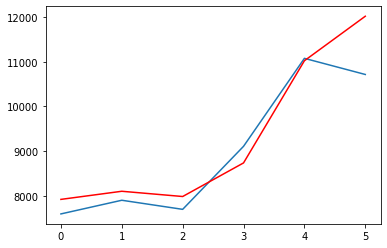

In [ ]:

import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # to convert it in the range of 0-1
from keras.models import Sequential # sequential
from keras.layers import Dense, LSTM, Dropout #output layer - dense - it is a layer to get te output,dropout - accuracy increases
import math 

from keras.layers import Bidirectional
from xlrd import *
from matplotlib import pyplot
# load dataset

crime = pd.read_excel('/gdrive/MyDrive/new_crime/KERALA (1).xlsx')
crime.columns = crime.columns.str.upper()
crime.drop('YEAR', axis= 1, inplace= True)
d = crime.drop('RAPE', axis=1).drop('IMPORTATION OF GIRLS', axis=1).drop('INSULT TO MODESTY OF WOMEN', axis=1).drop('CRUELTY BY HUSBAND OR HIS RELATIVES', axis=1).drop('STATE/UT', axis=1).drop('DOWRY DEATHS', axis=1).drop('ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY', axis=1).drop('KIDNAPPING AND ABDUCTION', axis=1)

print(d)
originsl_list = d.values
     
#scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))  #to convert to the data in the range of 0-1 (normalization of data)
training_set_scaled = sc.fit_transform(d)

#No Scaling
#training_set_scaled=d.values
print(training_set_scaled)



size = int(len(training_set_scaled)*0.6)
train, test = training_set_scaled[0:size], training_set_scaled[size:len(training_set_scaled)]
predictions = list()
observed = list()

X_train = []
y_train = []
X_train_list = []
y_train_list = []


for i in range(3,size):
    X_train_list.append(training_set_scaled[i-3:i,0])
    print(X_train_list)
    y_train_list.append(training_set_scaled[i,0])


X_train, y_train = np.array(X_train_list), np.array(y_train_list)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train)


rolling_index=size

# walk-forward validation
for t in range(len(test)):

    #convert type
    model = Sequential()
    model.add(Bidirectional(LSTM(25, activation='relu'), input_shape=(X_train.shape[1],1)))# denote the number of input x_....  
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.summary()
    
    #Compile Model
    model.compile(optimizer="adam", loss="mse") #adam= optimizer to control the condition of overfitting mse to find the loss(to determine the accuracy)
    model.fit(X_train,y_train,epochs=200, verbose=1) 


    #Scaling
    i1 = training_set_scaled[rolling_index-1]
    i2 = training_set_scaled[rolling_index-2]
    i3 = training_set_scaled[rolling_index-3]

    x = [i3, i2, i1]
    x = np.array(x)
    #x_reshaped = np.reshape(x,[-1,1])
    #x = sc.fit_transform(x_reshaped)
    print("x")
    print(x)
    x= x.reshape((1,X_train.shape[1],1))
    y = model.predict(x,verbose=0)

    print("y")
    print(y)
    result = sc.inverse_transform(y)   
    print("result")
    print(result)
    yhat = result[0][0]

    #No Scaling
    #yhat = y[0]
    predictions.append(yhat) 
    obs=originsl_list[rolling_index-1]
    #obs = test[t]
    observed.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

    #append for rolling forecast
    
    X_train_list.append(training_set_scaled[rolling_index-3:rolling_index,0])
    print(X_train_list)
    y_train_list.append(training_set_scaled[rolling_index,0])
    print(y_train_list)

    X_train, y_train = np.array(X_train_list), np.array(y_train_list)
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    rolling_index = rolling_index + 1


print("predictions")
print(predictions)
print("observed")
print(observed)
# evaluate forecasts
rmse = sqrt(mean_squared_error(observed, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(observed)
pyplot.plot(predictions, color='red')
pyplot.show()